## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy

In [3]:
import steadystate
import model
import graphs

-----
# Rebuilding Investment Based on Sharpe Ratio

In [571]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Variables for the simulation
    z_, xiz_, c_, n_, b_, w_, k_, m_, k__, q_, g_, s_, s0_, mu_, sig2_, news_, c0_, sharpe_ = x
        
    # Random technology process
    if p['steady_state']: 
        rand = np.random.normal(0,p['sigmaZ'])
    else: 
        rand = np.random.normal(0,p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)

    # Determine Consumption
    c = model.bisection(z, g_, k_, p)

    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
        
    # Income
    income = w * n + (b_  + q_ * k__) / (1 + p['inflation'])
    m = g_ * income - c 
    
    # Investment & Bonds
    investment = income * (1 - g_)
    b = (1 + p['interest']) * s_ * investment
    
    # Capital & Risky return
   
    k = (1 - p['depreciation']) * k_ + investment * (1 - s_)
    temp = (p['alpha'] * k ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    q = p['alpha'] * z * temp * k ** (rho - 1)
    
    # Returns to the household's portfolio
    #w_b = b_ / (b_ + k__)
    #port_ret = w_b * p['interest'] + (1 - w_b) * q_
    
    w_b = k_ / (b_+k_)
    port_ret = q_#k_ / (b_+k_) * q_
     
    # Expectations are based on EWMA (returns and volatility)
    
    mu =  p['memory_1'] * mu_ + (1 - p['memory_1']) * port_ret
    sig2 =  p['memory_1'] * sig2_ + (1 - p['memory_1']) * (port_ret - mu_)**2
    
    sharpe = (p['interest'] -  mu) / np.sqrt(sig2)
    
    
    
    c0 =  p['memory_2'] * c0_ + (1 - p['memory_2']) * ((c_/c)-1)
    
    
    
    s0 = sharpe
    news = p['ratio']*s0 + (1-p['ratio'])*(c0) #+ np.random.uniform(-p['ex_news'],p['ex_news'])
    
    # Risk-weighted excess returns are the signal
    if p['steady_state']: 
        s0 = 1e9 
         # s0 large = good signal
    
    # Decision on Spending and Investment Allocation
    g = g_
    
    financial_risk = np.random.beta(a=(k/n)*p['q_shock'], b=1)
    q = q * financial_risk
    
    s = 0.5 * ((p['s_max'] - p['s_min']) * np.tanh(p['s_theta'] * news) + p['s_max'] + p['s_min'])
    
    return z, xiz, c, n, b, w, k, m, k_, q, g, s, s0, mu, sig2, news, c0, sharpe

# TO CHANGE THE STEP DO NOT CHANGE THE RETURN VARIABLES

Observable stylized facts to check: <br>
- Magnitude of annualised Sharpe ratio
- Duration of crises 

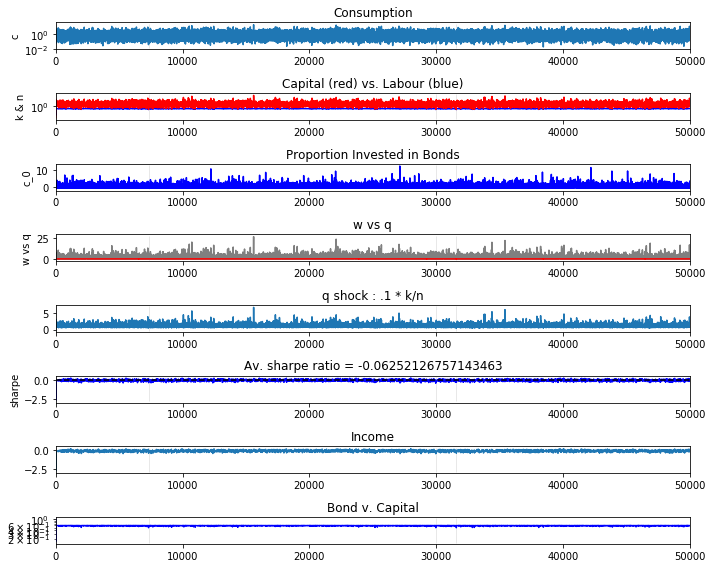

In [588]:
params = {
    # Noise Parameters
    'etaZ':0.5, 'zbar':1.0,
    # Empirical Parameters
    'inflation':0.0015, 'interest':0.001, 'depreciation':0.1,
    # Quasi-fixed parameters
    's_min':0, 's_max':1, 'memory_1':0.98,'memory_2':.5, 'gamma':1.0, 'alpha':0.33, 'mu':7.32,
    # Variable parameters
    'sigmaZ':.8, 'q_shock':.5, 's_theta':5, 'ratio':.8, 'steady_state' : False}

params_steady = copy.copy(params)
params_steady['depreciation'] = 0 
params_steady['steady_state'] = True 

start = dict(z=1, xiz=1, c=1, n=1, b=1, w=1, k=.1, m=0.0, k_=0.0, 
             q=0.02, g=0.7, s=0.5, s0=0.0, mu=0.01, sig2=1e-5, news=0, c0=0, income=0)

T = 50000
np.random.seed(40)
view = [0, T]

df_steady = model.simulate(start, params_steady, step_func=step, t_end=T, err = 1e-20)
df = model.simulate(start, params, step_func=step, t_end=T, err = 1e-20)

df.loc[:,'crisis'] = 0.5 * (1.0 + np.sign(df.n - df.k))
df.loc[:,'inv'] = 100 * (1-df.loc[:,'g'])
df.loc[:,'bc'] = df.b / df.c
df.loc[:,'utility'] = np.log(df.c) - params['gamma'] * (df.n ** 2)

df = df.iloc[view[0]:view[1],:]

plots = {
        'ln Consumption & Capital' : [df.loc[:,['c','k']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'M' : [df.m, False],
        'Crisis' : [df.crisis, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
    }


fig, ax = plt.subplots(nrows=8, ncols=1)
ax[0].plot(df.c, label='c')
#ax[0].plot(df_steady.c, color='yellow' , linestyle = '--')
ax[0].set_ylabel('c')
#ax[0].plot(df.c0, color='red')
ax[0].set_title('Consumption')
ax[0].set_yscale('log')

ax[1].plot(df.n, label='n', color='blue')
#ax[1].plot(df_steady.n, color = 'green')
ax[1].plot(df.k, label='k', color='red')
#ax[1].plot(df_steady.k, label='k', color='green')
ax[1].set_ylabel(r'k & n')
ax[1].set_title('Capital (red) vs. Labour (blue)')
ax[1].set_yscale('log')

ax[2].plot(df.c0, label='s', color='blue')
ax[2].set_ylabel(r'c_0')
#ax[2].plot(np.exp(df.c0), color='red')
ax[2].set_title('Proportion Invested in Bonds')

a = ax[5]
sharpe = df.s0
a.plot(sharpe, color='blue')

a.axhline(sharpe.mean(), linestyle = '--', color='black')
a.set_ylabel('sharpe')
a.set_title(r'Av. sharpe ratio = ' + str(sharpe.mean()))


ax[3].set_ylabel('w vs q')
ax[3].plot(df.w, label='s0', color='gray')
ax[3].plot(df.q, label='c0', color='red')
#ax[3].axhline(params['interest'], color='red', linestyle='--')
ax[3].set_title('w vs q')


ax[4].set_title(r'q shock : .1 * k/n')
ax[4].plot((df.k/df.n)*params['q_shock'])

ax[6].set_title(r'Income')
ax[6].plot(df.income)

ax[7].set_title(r'Bond v. Capital')
ax[7].plot(df.n, color='blue')
ax[7].set_yscale('log')

for a in ax:
    low,high = a.get_ylim()
    a.fill_between(df.index, low, high, where=df.n>df.k, alpha=0.5, color='lightgray')
    a.set_xlim(view[0], view[1])

fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

/Users/fedemoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/fedemoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


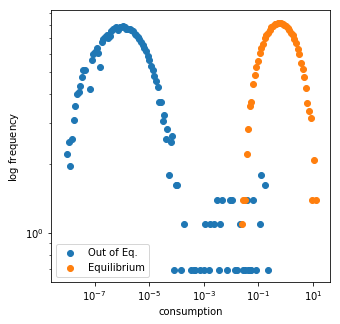

In [587]:
bins = np.logspace(-10,2,200)
histo = np.histogram(df.c , bins = bins)
histo_steady = np.histogram(df_steady.c , bins = bins)

fig, ax = plt.subplots(figsize= (5,5))
ax.plot(histo[1][:-1], np.log(histo[0]), 'o', label = r'Out of Eq.')
ax.plot(histo_steady[1][:-1], np.log(histo_steady[0]), 'o', label = r'Equilibrium')
ax.set_yscale('log')
ax.set_xlabel('consumption')
ax.set_ylabel(r'$\log$ frequency')
ax.set_xscale('log')
plt.legend()

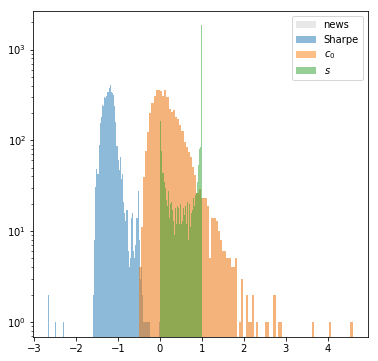

In [562]:
fig, ax = plt.subplots(figsize = (6,6))
ax.hist(df.news, bins=100, label='news', color='lightgray', alpha=0.5)
ax.hist(df.s0, bins=100, label='Sharpe', alpha=0.5)
ax.hist(df.c0, bins=100, label=r'$c_0$', alpha=0.5)
ax.hist(df.s, bins=100, label=r'$s$', alpha=0.5)
ax.set_yscale('log')
ax.legend()
plt.show()

In [195]:
def crises_len(v):
    crisis = []
    for i in range(1,len(v)-1):
        cr_len = 0
        count = 0
        bool_cr = False
        if v[i] == 1 and v[i-1] == 0:
            bool_cr = True
            count = 1
            
        while bool_cr:
            if v[i+count]==1 and i + count < len(v)-1:
                count+=1
            else:
                bool_cr = False
        i+=count
        if count !=0 :
            crisis.append(count)
    return crisis

In [10]:
crises_len(crises)

NameError: name 'crises' is not defined

In [11]:
crises = .5 * (1.0 + np.sign(df.n - df.k ))
crises = crises_len(crises)


fig, ax = plt.subplots(1,2,figsize = (9,4))

ax[0].hist( 100*(1 - df.s), bins = np.logspace(-2,2,100))
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].hist( crises, bins = np.linspace(0,max(crises),20))
ax[1].set_yscale('log')

KeyError: 1

In [22]:
alpha=0.3 

x = []
x.append(0)
dx = .1
for i in range(100):
    x.append(alpha*x[-1] + dx)
    

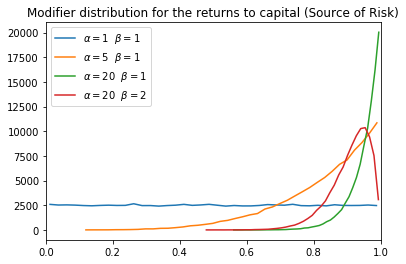

In [554]:
 fig, ax = plt.subplots()
ax.set_title('Modifier distribution for the returns to capital (Source of Risk)')
combos = [(1,1), (5,1), (20,1), (20,2)]
for c in combos:
    name = r'$\alpha=${:.0f}  $\beta=${:.0f}'.format(*c)
    n,x = np.histogram(np.random.beta(a=c[0], b=c[1], size=100000), bins = 40)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax.plot(bin_centers, n, label=name)
    #ax.hist(np.random.beta(a=c[0], b=c[1], size=100000), bins=40, alpha=0.5, label=name)

ax.set_xlim(0,1)
plt.legend()
plt.show()

In [93]:
params['depreciation']

0.01

In [111]:
params_steady = copy.copy(params)


In [158]:
df.sharpe

AttributeError: 'DataFrame' object has no attribute 'sharpe'

In [38]:
sigmaZ = 0.4
etaZ = 0.95
T = 1000

z = np.ones(T)
xiz = np.zeros(T)

for t in range(1,T):
    rand = np.random.normal(0,sigmaZ)
    xiz[t] = etaZ * xiz[t-1] + np.sqrt(1 - etaZ ** 2) * rand
    z[t] = np.exp(xiz[t])

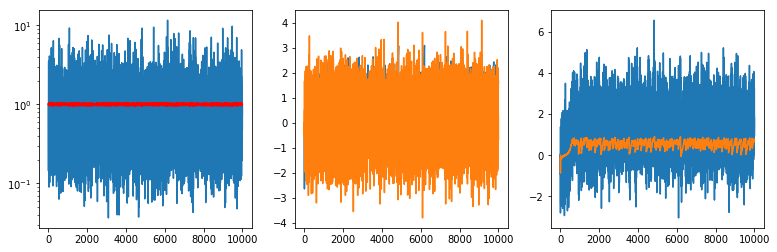

In [370]:
alpha = 0.98
test = df.c
ema = np.zeros(T)
for t in range(1,T):
    ema[t] = alpha*ema[t-1] + (1-alpha)*(-np.log(test[t]/test[t-1]))
    
fig, ax = plt.subplots(1,3,figsize = (13,4))
ax[0].plot(test)
ax[0].plot(np.exp(ema), color = 'red')
ax[0].set_yscale('log')
ax[1].plot(df.s0)
ax[1].plot(df.c0)
ax[2].plot(df.c0+df.s0)
ax[2].plot(np.tanh(.5*(ema+df.s0)))

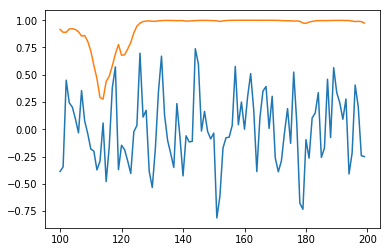

In [384]:
plt.plot(df.c0[100:200])
plt.plot(df.s0[100:200])
plt.plot(df.s0[100:200])